# MORINGA DATA SCIENCE PHASE 3 Project

Before delving into the details of the project, it is important to clarify which dataset was used. There was an option of 5 different standard datasets that were provided [here](https://drive.google.com/drive/u/4/folders/15bI18N2wQXF11C-CE3ihul_DD7axSQwK), or one had the option of selecting your own dataset. 

I chose to use the [SyriaTel Customer Churn dataset](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset/data).

## **1. BUSINESS UNDERSTANDING**

SyriaTel, one of the three main telecommunications providers in Syria as of 2022, was founded in 2000. At its inception, the company was partly owned by Egyptian telecommunications company Orascom - who had a 25% ownership stake - while the rest was owned by Rami Makhlouf, cousin to the current Syrian presidenet Bashar al-Assad. Headquartered in Damascus, Syria, the company boasted 8 million customers as of 2016. Such levels of success led the company to launch its own 4G network, with speeds reaching up to 150Mb/s.

However, having noticed some concerning trends in the last few years, SyriaTel reached out to have a data analysis conducted and subsequent model built. The purpose of these was to notice if there are any trends that would give insight as to whether a customer would stop using their services, and if possible, when they would stop. 

SyriaTel provided a dataset, which is located in the `data` folder. From this, the shareholders of the company expect there to be a model that predicts when a customer will stop doing business with SyriaTel. It is of importance to note that this prediction will not take into account the political climate of the country, but simply look at the data and from it, estimate when a client is most likely going to stop using the company's services.



## ***Preliminaries***

To begin with, all the relevant packages are imported at the very beginning to ensure no packages that are used are missing.

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_curve, precision_score,recall_score,f1_score,auc,precision_recall_curve
from sklearn import tree
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import BaggingClassifier,BaggingRegressor,GradientBoostingClassifier,GradientBoostingRegressor

from imblearn.over_sampling import SMOTE

%matplotlib inline

As the concepts of Object-Oriented Programming are now more familiar, the code required to manipulate the data we receive will be split into four classes: 
1. Data Sourcing
2. Data PreProcessing
3. Data Analysis
4. Model Deployment

The classes themselves, along with their respective functions, are listed below. It is crucial that each of the cells is run in order to ensure that there are no errors. All the code that is used to manipulate the data will be found in the 4 classes below.

In [29]:
class DataSourcing:
  def __init__(self,dataframe):
    self.original = dataframe
    self.dataframe = dataframe
  
  def give_info(self):
    message =  f"""
    ----------------------------------------------------------------------->
    DESCRIPTION OF THE DATAFRAME IN QUESTION:
    ----------------------------------------------------------------------->
    
    Dataframe information => {self.dataframe.info()}
    ------------------------------------------------------------------------------------------------------------------------->
    
    Dataframe shape => {self.dataframe.shape[0]} rows, {self.dataframe.shape[1]} columns
    ------------------------------------------------------------------------------------------------------------------------->    
    
    There are {len(self.dataframe.columns)} columns, namely: {self.dataframe.columns}.  
    ------------------------------------------------------------------------------------------------------------------------->
        
    The first 5 records in the dataframe are seen here:
    ------------------------------------------------------------------------------------------------------------------------->
    {self.dataframe.head()}
    ------------------------------------------------------------------------------------------------------------------------->
       
    The last 5 records in the self.dataframe are as follows: 
    ------------------------------------------------------------------------------------------------------------------------->
    {self.dataframe.tail()}
    ------------------------------------------------------------------------------------------------------------------------->
    
    The descriptive statistics of the dataframe (mean,median, max, min, std) are as follows:
    ------------------------------------------------------------------------------------------------------------------------->
    {self.dataframe.describe()}
    ------------------------------------------------------------------------------------------------------------------------->
    """
    print (message)
  
  def null_count(self):
    return self.dataframe.isnull().sum()
  
  def unique_count(self):
    return self.dataframe.nunique()
  
  def unique_per_column(self):
    print("<----- UNIQUE VALUES IN EACH COLUMN ----->")
    for col in self.dataframe.columns:
      print(f"{col} : \n {self.dataframe[col].unique()}")
      print()
    print("<----- END OF UNIQUE VALUES IN EACH COLUMN ----->")
    return
  
  def plot_barplot(self,dataframe,x,y,x_title,y_title):
    fig,ax = plt.subplots(figsize=(10,8))
    
    sns.barplot(data = dataframe,x=x, y=y,orient='h',errorbar=None)
    ax.set_title(f"{y_title} vs {x_title}")
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
  
  def plot_boxplot(self,dataframe,x,y,x_title,y_title):
    fig,ax = plt.subplots(figsize=(10,8))
    
    sns.boxplot(data = dataframe,x=x, y=y)
    ax.set_title(f"{y_title} vs {x_title}")
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.xticks(rotation=90)
    plt.show()

In [30]:
class DataPreProcessing(DataSourcing):
  def __init__(self, dataframe):
    super().__init__(dataframe)

  def dropColumns(self, columns):
    return self.dataframe.drop(columns, axis=1)

  def dropRows(self, rows):
    return self.dataframe.drop(rows, axis=0)

  def preprocess_data(self):
      cols_to_drop = ["total day calls", "total night calls", "total eve calls", "total intl calls","total day minutes", "total night minutes", "total eve minutes", "total intl minutes","total day charge", "total night charge", "total eve charge", "total intl charge"]           

    # Calculate total calls
      self.dataframe["total_calls"] = self.dataframe["total day calls"] + self.dataframe["total night calls"] + self.dataframe["total eve calls"] + self.dataframe["total intl calls"]

    # Calculate total minutes
      self.dataframe["total_minutes"] = self.dataframe["total day minutes"] + self.dataframe["total night minutes"] + self.dataframe["total eve minutes"] + self.dataframe["total intl minutes"]

    # Calculate total charges
      self.dataframe["total_charges"] = self.dataframe["total day charge"] + self.dataframe["total night charge"] + self.dataframe["total eve charge"] + self.dataframe["total intl charge"]

    # Drop columns
      self.dataframe.drop(columns=cols_to_drop,inplace=True)
      
      return self.dataframe
    
  def one_hot_encode(self):
    # Creating One-Hot Encoder
    ohe = OneHotEncoder(drop="first", sparse_output=False)
    
    # Selecting dataframe with desired columns to OHE
    df = self.dataframe[['international plan', 'churn', 'voice mail plan']].copy()
    # Specifying dataframe without OHE columns
    df_dropped = self.dataframe.drop(columns=['international plan', 'churn', 'voice mail plan']).copy()
    
    # Encoding categorical columns and transferring them into a df
    data_cat_ohe = pd.DataFrame(data=ohe.fit_transform(df), columns=[f"{col}_{cat}" for col in df.columns for cat in ohe.categories_[0][1:]])

    # Adding to original dataframe
    self.dataframe = pd.concat([df_dropped,data_cat_ohe],axis=1)
    return self.dataframe

In [31]:
class DataAnalysis(DataPreProcessing, DataSourcing):
    def __init__(self,dataframe):
        super().__init__(dataframe)

    def univariate_analysis(self):

        numeric_columns = self.dataframe.select_dtypes(include=['number']).columns
        categorical_columns = self.dataframe.drop(
            columns=['phone number']).select_dtypes(exclude=['number']).columns
        # Plot histograms and box plots for numeric columns
        for column in numeric_columns:

            plt.figure(figsize=(12, 6))

            # Plot histogram
            plt.subplot(1, 2, 1)
            sns.histplot(self.dataframe[column], bins=30, kde=True)
            plt.title(f'Histogram for {column}')

            # Plot box plot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=self.dataframe[column])
            plt.title(f'Box Plot for {column}')

            plt.show()

        # Plot count plots for categorical columns
        for column in categorical_columns:
            plt.figure(figsize=(12, 6))

            # Plot count plot
            sns.countplot(x=self.dataframe[column])
            plt.title(f'Count Plot for {column}')

            plt.show()

    def bivariate_analysis(self, column_of_interest):

        numeric_columns = self.dataframe.select_dtypes(include=['number']).columns
        categorical_columns = self.dataframe.drop(
            columns=['phone number']).select_dtypes(exclude=['number']).columns

        numeric_columns = self.dataframe.select_dtypes(include='number').columns

        for column in numeric_columns:
            # Plot histplot
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            sns.histplot(
                x=self.dataframe[column], hue=self.dataframe[column_of_interest], bins=30, kde=True)
            plt.title(f'Histplot for {column} by {column_of_interest}')

        # Plot box plot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=self.dataframe[column_of_interest], y=self.dataframe[column])
            plt.title(f'Box Plot for {column_of_interest} by {column}')

            plt.show()

        # Plot count plots for categorical columns
        for outer in categorical_columns:

            plt.figure(figsize=(12, 6))

            # Plot count plot
            sns.scatterplot(x=self.dataframe[outer], y=self.dataframe["churn"])
            plt.title(f'Count Plot for churn vs.{outer}')

            plt.show()

    def churn_by_state(self):
        self.dataframe.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)) 

    def churn_by_area_code(self):
        self.dataframe.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5))

    def churn_by_int_plan(self):
        self.dataframe.groupby(["international plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

    def churn_by_vm_plan(self):
        self.dataframe.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

In [32]:
class Modeling():
    def __init__(self,dataframe):
        self.dataframe = dataframe
    
    def label_encoder(self):
        le = LabelEncoder()
        self.dataframe["churn"] = le.fit_transform(self.dataframe["churn"])
        self.dataframe['state'] = le.fit_transform(self.dataframe['state'])
        self.dataframe['area code'] = le.fit_transform(self.dataframe['area code'])
        self.dataframe['international plan'] = le.fit_transform(self.dataframe['international plan'])
        self.dataframe['voice mail plan'] = le.fit_transform(self.dataframe['voice mail plan'])
        return self.dataframe

    def smote(self,X_train,y_train):
        # X = self.dataframe.drop(columns=["churn", "phone number"], axis=1)
        # y = self.dataframe["churn"]
        
        sm = SMOTE(k_neighbors=5, random_state=123)
        X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
        print(f"""
              |-----------| Before Oversampling | After Oversampling       |
              | X_train   |   {X_train.shape}   |   {X_train_over.shape}   |
              | y_train   |   {y_train.shape}   |   {y_train_over.shape}   |
              """)

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)

        # Display confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d",
                    cmap="Blues", annot_kws={"size": 16})
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
        return cm

    def scale_data(self,var_to_scale):
        scaler = StandardScaler()
        var_scaled = scaler.fit_transform(var_to_scale)
        return var_scaled
    
    def evaluate_model(self,X_test,y_test,model):
        y_pred = model.predict(X_test)
        
        score = model.score(X_test, y_test)
        # con_mat = self.plot_confusion_matrix(y_test, y_pred)
        con_mat = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        return y_pred,score, con_mat,precision,recall,f1,report
    
    def train_test_split(self, target_class, test_size=0.2, random_state=42):
        X = self.dataframe.drop(columns=["churn", "phone number"], axis=1)
        y = self.dataframe["churn"]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y)
        return X_train, X_test, y_train, y_test

    def logistic(self, X_train, X_test, y_train, y_test):
        X_train_scaled = self.scale_data(X_train)
        X_test_scaled = self.scale_data(X_test)
        
        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)
        
        y_pred, score, con_mat, precision, recall, f1, report = self.evaluate_model(
            X_test_scaled, y_test, model)
        
        print(f"""
              <-------- Logistic Regression Results --------->
              Accuracy : {score}
              
              Confusion Matrix : {con_mat}
              
              Precision Score: {precision}
              
              Recall Score: {recall}
              
              F1 Score: {f1}
              
              Classification Report :
              {report}
              """)
        return score,con_mat,report

    def decision_tree(self, X_train, X_test, y_train, y_test):
        X_train_scaled = self.scale_data(X_train)
        X_test_scaled = self.scale_data(X_test)

        model = DecisionTreeClassifier()
        model.fit(X_train_scaled, y_train)

        y_pred, score, con_mat, precision, recall, f1, report = self.evaluate_model(
            X_test_scaled, y_test, model)

        print(f"""
              <-------- Decision Tree Results --------->
              Accuracy : {score}

               Confusion Matrix : {con_mat}

              Precision Score: {precision}

              Recall Score: {recall}

              F1 Score: {f1}

              Classification Report :
              {report}
              """)
        return model

    def random_forest(self, X_train, X_test, y_train, y_test):
        X_train_scaled = self.scale_data(X_train)
        X_test_scaled = self.scale_data(X_test)

        model = RandomForestClassifier()
        model.fit(X_train_scaled, y_train)

        y_pred, score, con_mat, precision, recall, f1, report = self.evaluate_model(
            X_test_scaled, y_test, model)
        
        y_prob = model.predict_proba(X_test_scaled)[:, 1]

        print(f"""
              <-------- Random Forest Results --------->
              Accuracy : {score}%

              Confusion Matrix : {con_mat}

              Precision Score: {precision}

              Recall Score: {recall}

              F1 Score: {f1}

              Classification Report :
              {report}
              """)
        return model

    def hyperparameter_tuning(self, X_train, X_test, y_train, y_test):
        model = RandomForestClassifier()
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        grid_search = GridSearchCV(model, param_grid, cv=5,n_jobs=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        score = best_model.score(X_test, y_test)

        con_mat = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        print(f"""
              <-------- Hyperparameter Tuning Results --------->
              Best Model Parameters: {grid_search.best_params_}
              Accuracy : {score}%

              Confusion Matrix : {con_mat}
              
              Precision Score: {precision_score(y_test,y_pred)}

              Recall Score: {recall_score(y_test,y_pred)}

              F1 Score: {f1_score(y_test,y_pred)}

              Classification Report :
              {report}
              """)
        return model
    
    def roc_auc_curve_plotter(self, models, X_test, y_test):
        plt.figure(figsize=(8, 6))
        
        for model in models:
            if isinstance(model, tuple):
                model, X_test_scaled = model
            else:
                X_test_scaled = self.scale_data(X_test)
        
            if hasattr(model, 'predict_proba'):
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
            else:
                y_prob = model.predict(X_test_scaled)
            
            # For binary classification
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    
    def precision_recall_curve_plotter(self,models,X_test,y_test):
        plt.figure(figsize=(8, 6))

        for model in models:
            # For binary classification
            precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
            pr_auc = auc(recall, precision)
            plt.step(recall, precision, color='b', alpha=0.2, where='post')
            plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

        # Plot the Precision-Recall curve
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(pr_auc))
        plt.show()

## **2. DATA UNDERSTANDING**

The identification, gathering, and cursory analysis of the data in this part will be carried out by:

- gathering preliminary data, which has been put into a CSV file.
- describing the data that we have at our disposal.
- looking for patterns and correlations in the data.
- confirming the accuracy of the data.

Firstly, to open the dataset provided, we will utilise pandas rather than any specific custom class. This is because the classes take a dataframe as a positional argument, and pandas provides several methods for opening different kinds of data files.

In [33]:
df_raw = pd.read_csv('./data/telecom.csv')

Now that we have a dataframe of our dataset, we can pass that dataframe to our `DataSourcing` class and begin the process of data understanding.

In [34]:
data_sourcing = DataSourcing(dataframe=df_raw)
data_sourcing.give_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

From the `give_info()`method, we have established some crucial facts about the dataset that will aid in our understanding of it:

- The shape - the dataset has 3333 rows and 21 columns
- Out of the 21 columns, only 5 columns contain data that is in non-numerical formats (i.e. 4 objects and 1 boolean column). 
- From the first look, none of the columns has any null values. This, hweoever, does not rule out the possibility of having placeholder values.
- The names of the columns seem to be self-explanatory, with no column in particular needing a closer look into to understand what type of data is collected by it.

Next, a closer look into the data in the columns will be done. This is to ensure that we truly do not have any placeholder values in any of the columns that could be masquerading as legitimate values. To simplify this process, we will simply look at the columns that do not contain numerical data first. However, all columns will be looked at as there may be some values in the numerical columns that do not make sense, and can thus be considered placeholder values.

In [35]:
data_sourcing.unique_count()

state                       51
account length             212
area code                    3
phone number              3333
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

Let us get a better breakdown of the unique values in each column by calling the `unique_per_col` method.

In [36]:
data_sourcing.unique_per_column()

<----- UNIQUE VALUES IN EACH COLUMN ----->
state : 
 ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']

account length : 
 [128 107 137  84  75 118 121 147 117 141  65  74 168  95  62 161  85  93
  76  73  77 130 111 132 174  57  54  20  49 142 172  12  72  36  78 136
 149  98 135  34 160  64  59 119  97  52  60  10  96  87  81  68 125 116
  38  40  43 113 126 150 138 162  90  50  82 144  46  70  55 106  94 155
  80 104  99 120 108 122 157 103  63 112  41 193  61  92 131 163  91 127
 110 140  83 145  56 151 139   6 115 146 185 148  32  25 179  67  19 170
 164  51 208  53 105  66  86  35  88 123  45 100 215  22  33 114  24 101
 143  48  71 167  89 199 166 158 196 209  16  39 173 129  44  79  31 124
  37 159 194 154  21 133 224  58  11 109 102 165  18  30 176  47 190 152
  26  69 1

Looking at this data, it seems genuine and with no faults for a number of reasons:

- It is noted that there are 3333 unique phone numbers. This is expected as we do not expect 2 different individuals to have the same phone number. Thus, each record should have a unique phone number, and a variation from this indicates that further data cleaning needs to be done.
- The columns containing the calls, charges and minutes all have reasonable floats as data within them. Furthermore, no unreasonable values are stored in columns that would be less likely to have them e.g. a value of 999 in the total night charge. Such an out of place value would indicate a placeholder or a grave error.
- For such a small country, the presence of 51 states would ring alarm bells. However, after further research, it is entirely possibly that these 'states' are what are referred to as 'districts', of which there are 65. This makes sense as in reality, telecommuncations providers will not provide a country with 100% network coverage since that doesn't make financial sense in areas that are sparsely populated.
- In the columns with a dtype = object, there are no values e.g. '?' or 'NaN' that indicate missing or placeholder values.

From this, **no (further) data cleaning is required.**

To better understand this data, some preliminary visualisations can be made to graphically view the relationships of features

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


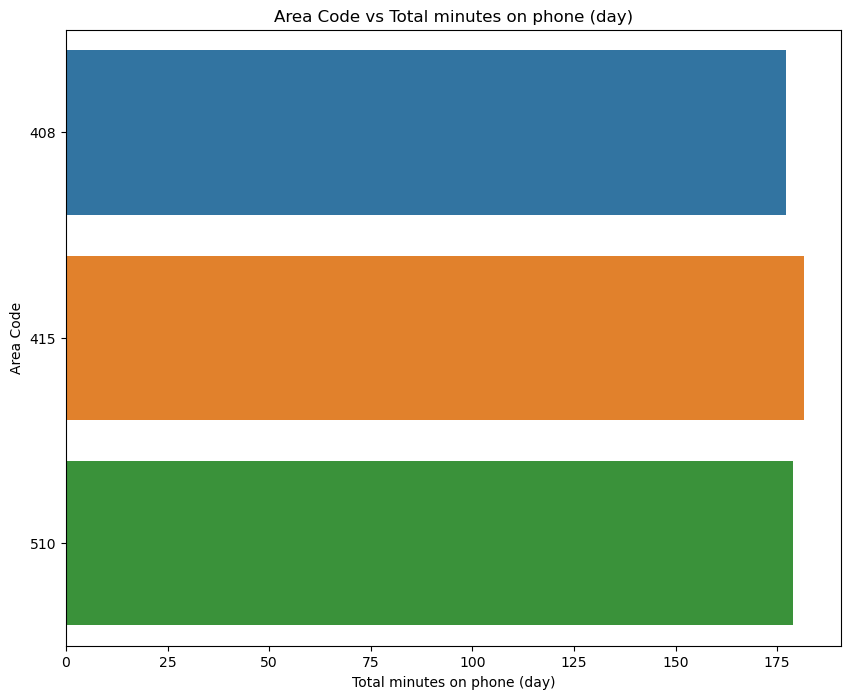

In [37]:
data_sourcing.plot_barplot(data_sourcing.dataframe.sort_values(by='area code',ascending=False),x='total day minutes',y='area code',x_title='Total minutes on phone (day)',y_title='Area Code')

We can also take a look at the total minutes categorised by state, looking first at the 20 states that have the most collective minutes used.                 

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


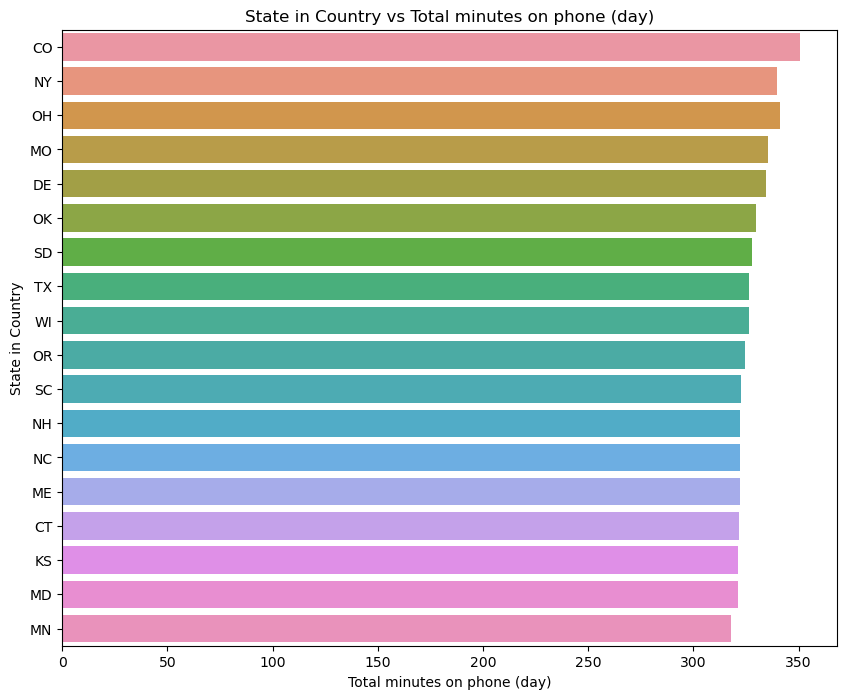

In [38]:
data_sourcing.plot_barplot(data_sourcing.dataframe.sort_values(by='total day minutes', ascending=False).head(20),x='total day minutes',y='state',x_title='Total minutes on phone (day)',y_title='State in Country')

Likewise, we can establish the 20 provinces with the least minutes during the day

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


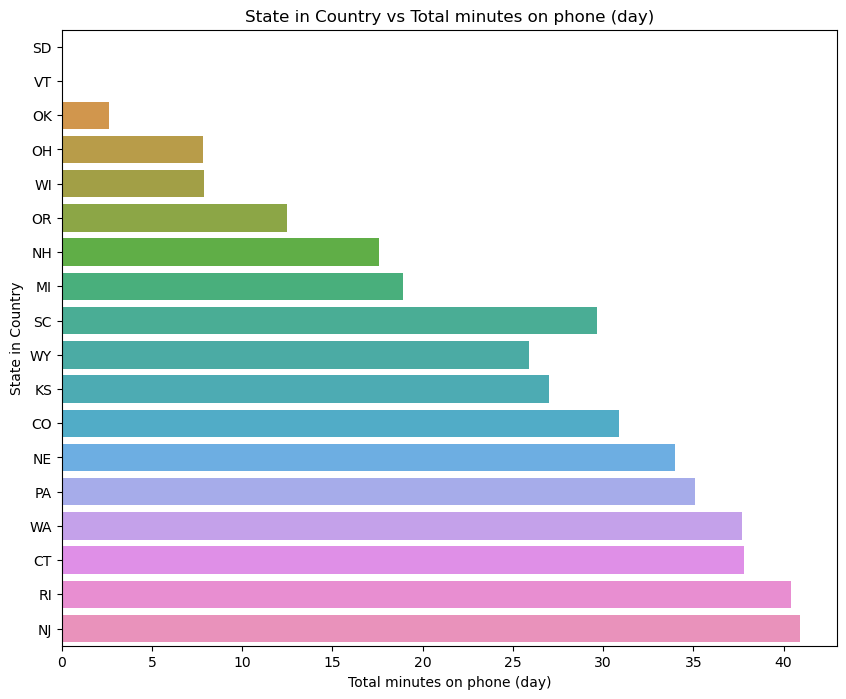

In [39]:
data_sourcing.plot_barplot(data_sourcing.dataframe.sort_values(by='total day minutes', ascending=True).head(20), x='total day minutes',y='state',x_title='Total minutes on phone (day)',y_title='State in Country')

# **3. DATA PREPARATION**

Now that we have a good understanding of the data at hand, it is time to take it through preprocessing, which will prepare it for analysis. 

### **3.1. DATA PREPROCESSING**

This stage involves the following steps:

- Handle missing values through imputation or removal.
- Identify and handle duplicate records.
- Detect and handle outliers appropriately.

As noted in Section 2 - Data Understanding, we do not have any missing values. Furthermore, no duplicate records were detected.
When it comes to outliers, these can be easily spotted by charting a boxplot. 

Take, for example, a boxplot showing the total day minutes per state:

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


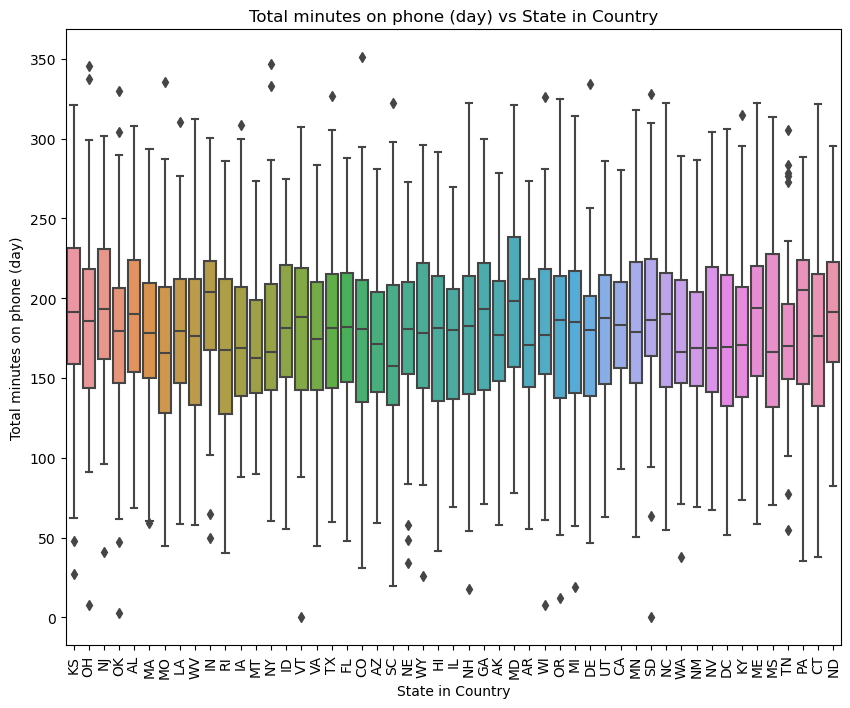

In [40]:
data_sourcing.plot_boxplot(data_sourcing.dataframe,y='total day minutes',x='state',y_title='Total minutes on phone (day)',x_title='State in Country')

Despite these outliers indicating strange usage patterns, it was deemed that they were still necessary to the dataset. Greatly reduced/ increased usage of minutes during the day was deemed as expected given the political instability in the region as a whole, thus it was concluded that these outliers - despite skewing the data - are to be expected frequently and thus must be accounted for in the dataset.

When taking a closer look at some of the columns in the data, it was noted that there are columns that talk about similar matters, with only very slight differences e.g. `total day minutes`, `total eve minutes`, `total night minutes` and `total intl minutes` all refer to the minutes spent talking, just across different times and areas. These same 4 categories apply for the charges and calls. 

Such a distinction does *NOT* need to be made, thus the columns will all be merged to one respective column that contains the `total minutes`, `total charges` and `total calls` across the original 4 columns. This will be done by calling the `preprocess_data` method in the DataPreProcessing class.

In [41]:
data_prep = DataPreProcessing(dataframe=data_sourcing.dataframe)
data_prep.preprocess_data()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,customer service calls,churn,total_calls,total_minutes,total_charges
0,KS,128,415,382-4657,no,yes,25,1,False,303,717.2,75.56
1,OH,107,415,371-7191,no,yes,26,1,False,332,625.2,59.24
2,NJ,137,415,358-1921,no,no,0,0,False,333,539.4,62.29
3,OH,84,408,375-9999,yes,no,0,2,False,255,564.8,66.80
4,OK,75,415,330-6626,yes,no,0,3,False,359,512.0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,2,False,292,660.7,60.10
3329,WV,68,415,370-3271,no,no,0,3,False,239,585.4,63.53
3330,RI,28,510,328-8230,no,no,0,2,False,264,675.6,67.74
3331,CT,184,510,364-6381,yes,no,0,2,False,336,517.6,57.53


### **3.2. DATA ANALYSIS (EDA)**

The EDA process will begin by instantiating a DataAnalysis class, which takes the dataframe that was worked on in the preprocessing stage as an argument.

In [42]:
data_analysis = DataAnalysis(dataframe=data_prep.dataframe)

From this, exploratory relationships between the variables can be conducted. 

A univariate and bivariate analysis will both be carried out, graphically depicting the relationships of the variables to each other. This is espeically useful to identify any trends that may exist in the data thus far.

We shall start with the univariate analysis by calling the `univariate_analysis` method on our instantiated data_analysis class.


e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


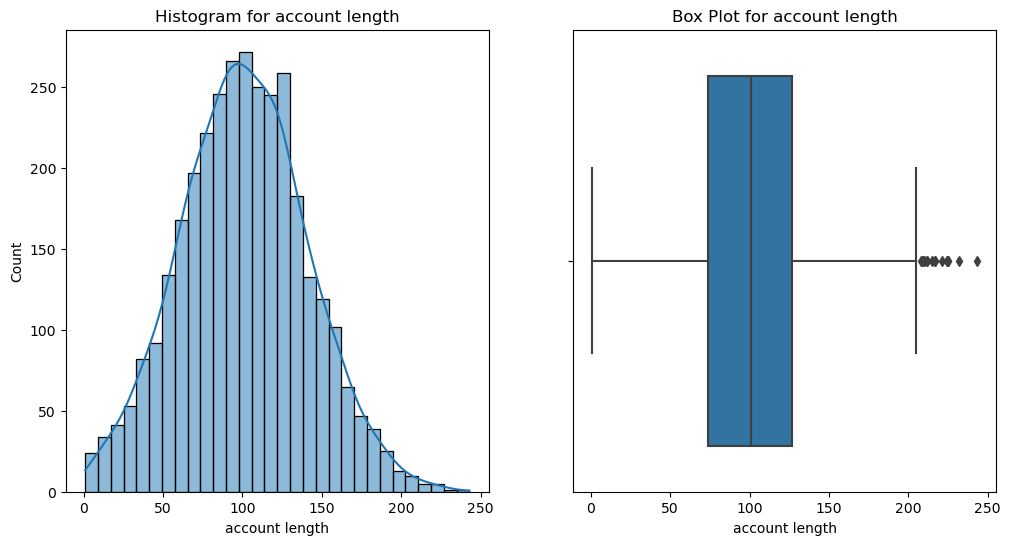

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


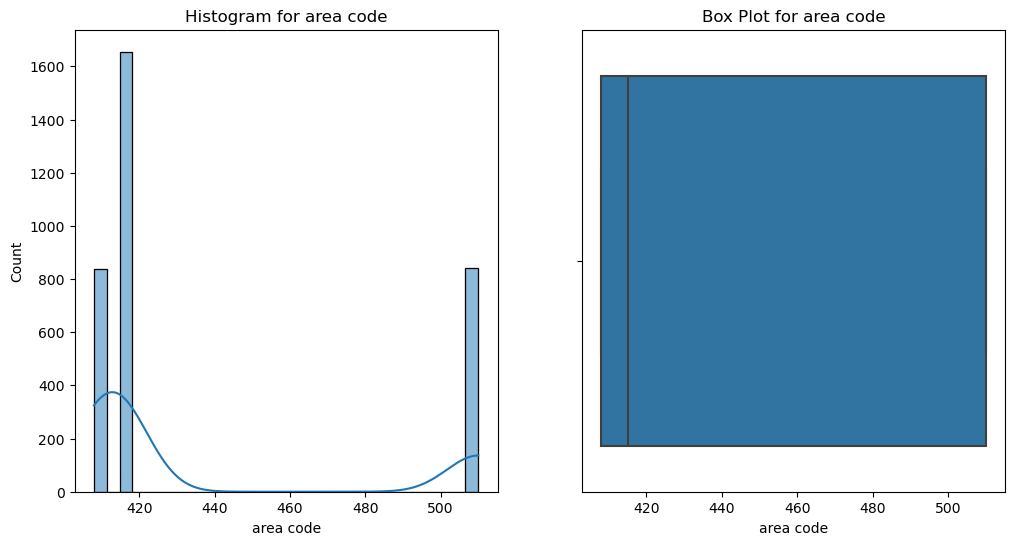

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


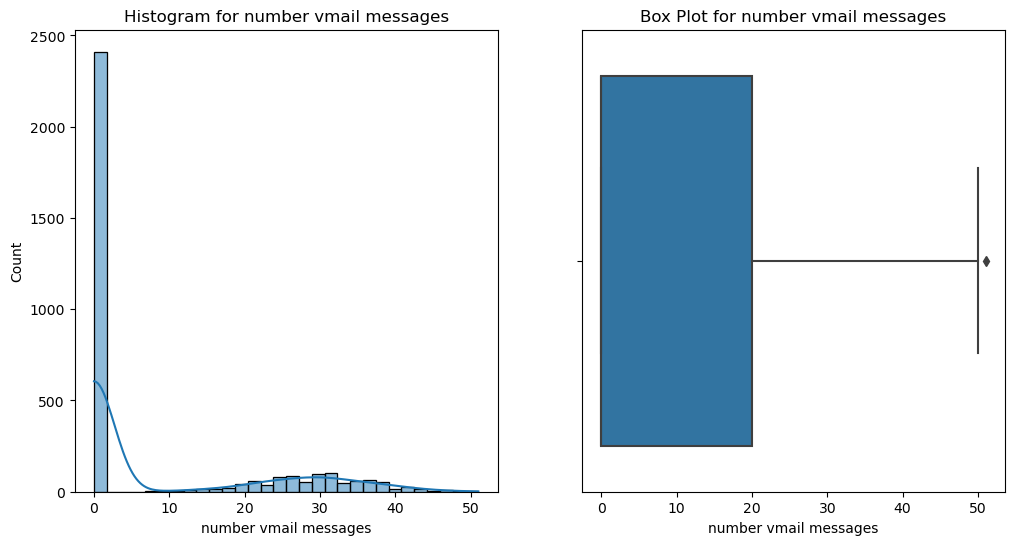

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


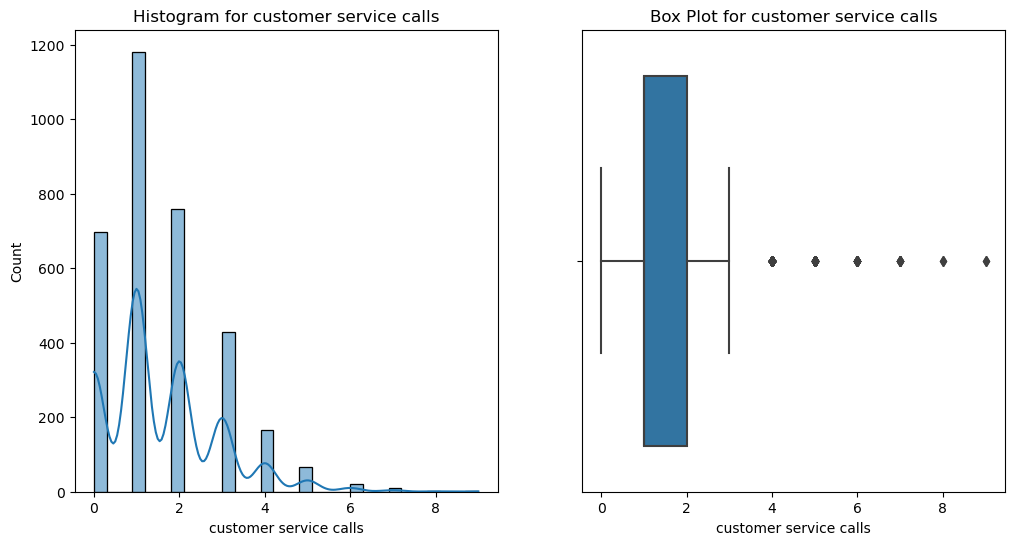

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


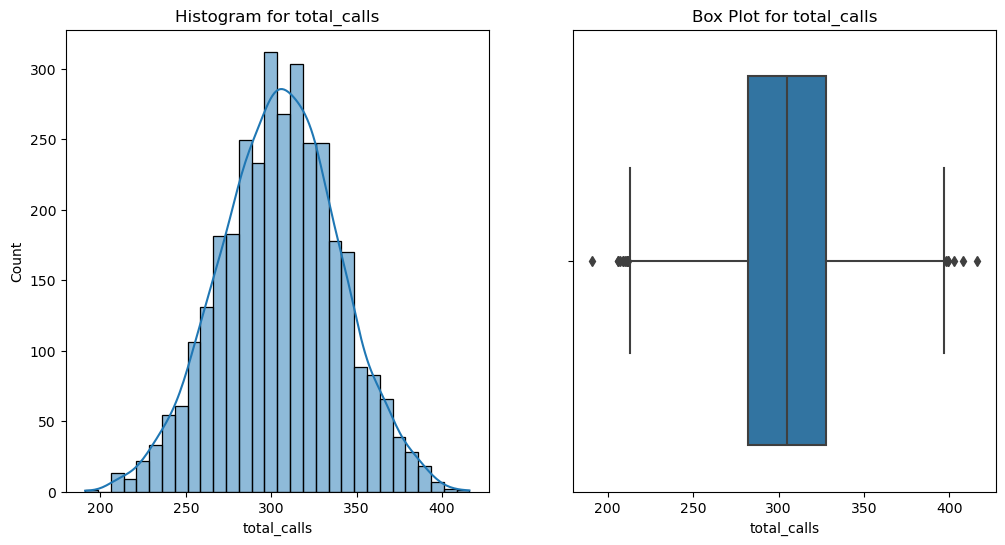

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


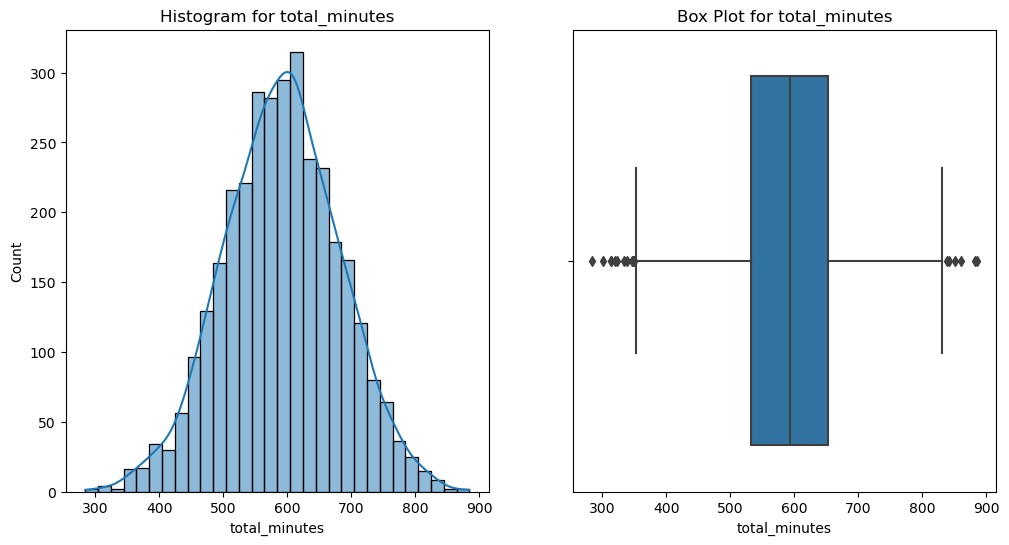

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


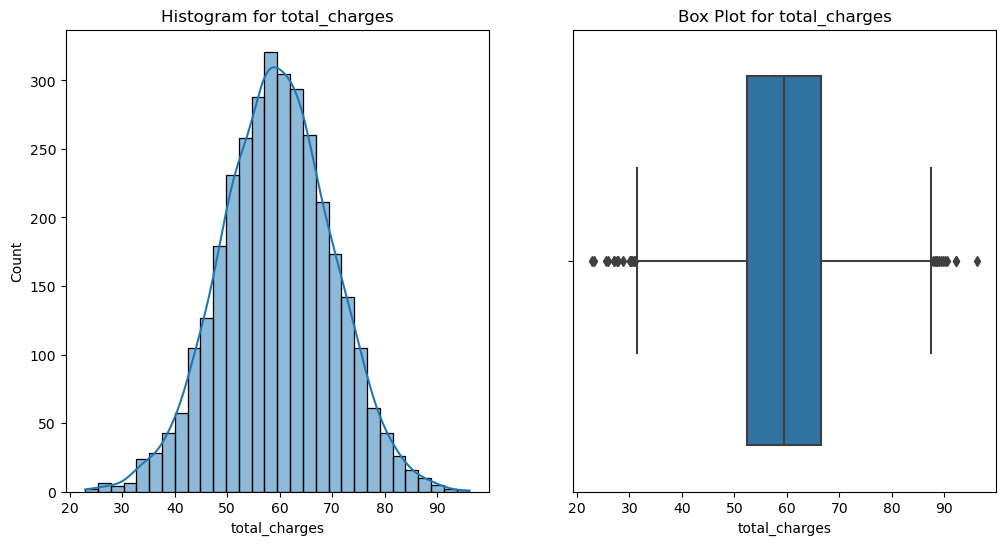

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


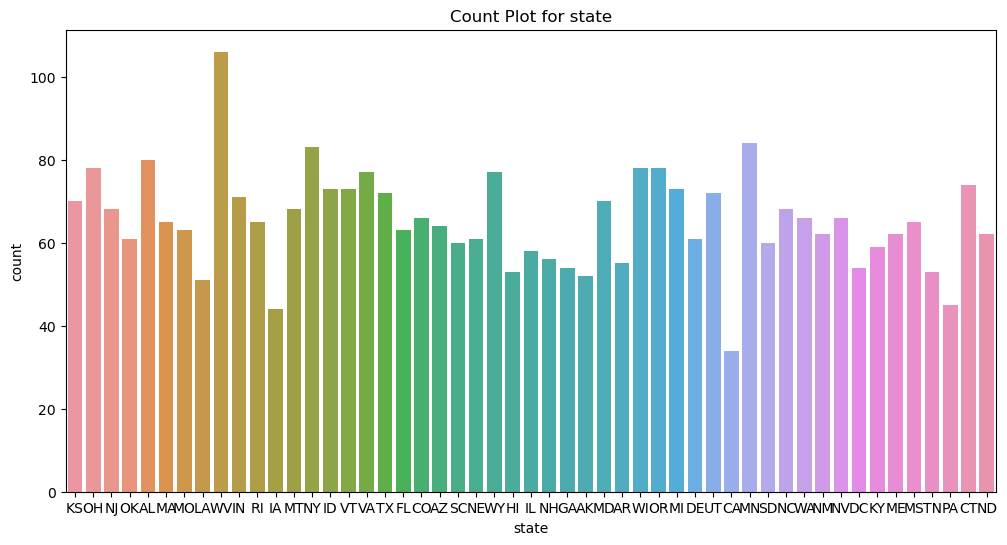

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


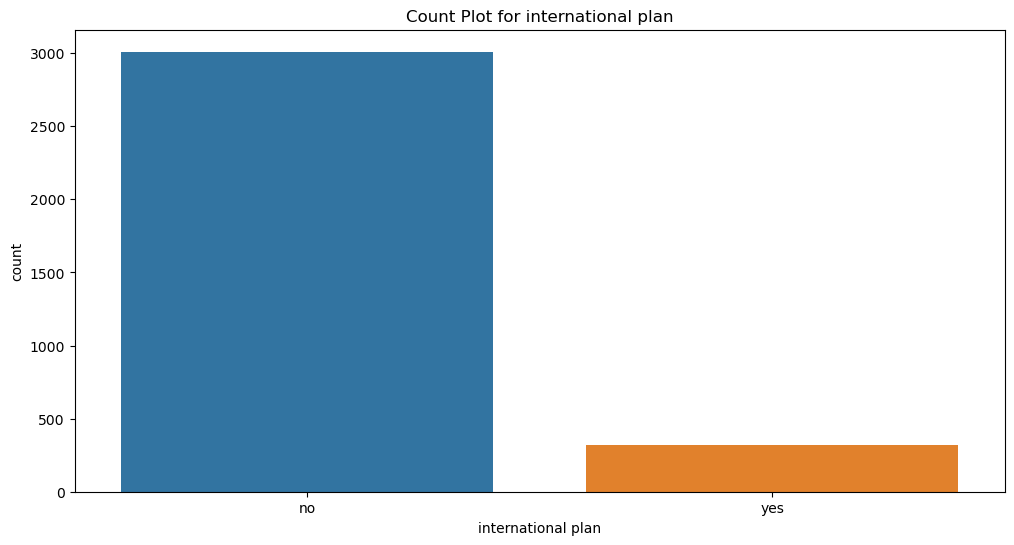

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


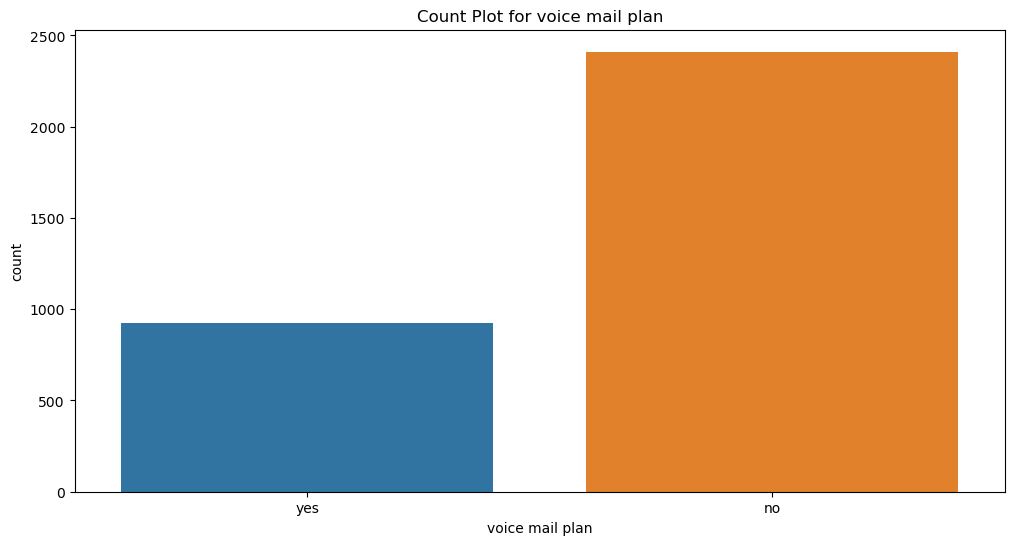

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


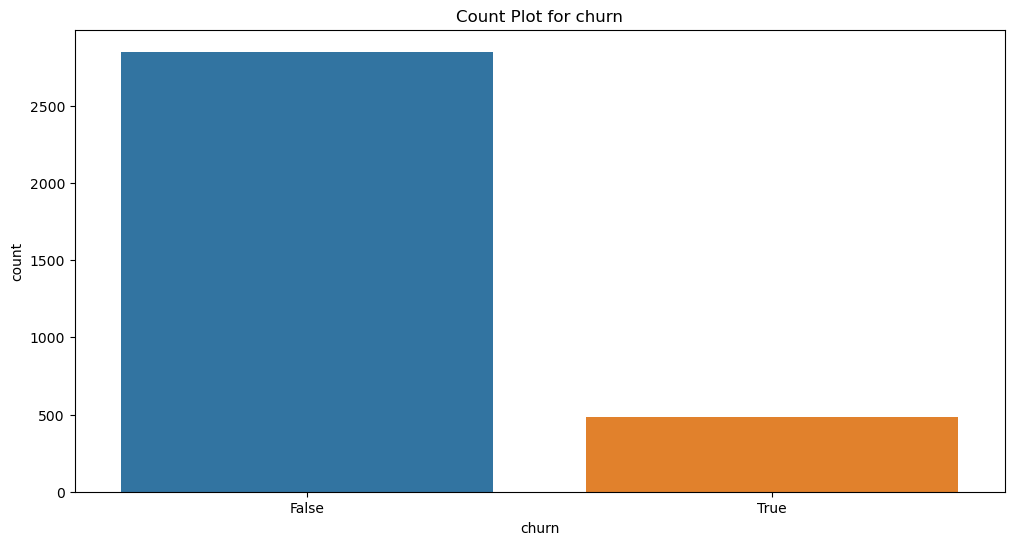

In [43]:
data_analysis.univariate_analysis()

Now we can carry out the bivariate analysis. With this analysis, we will focus on the `churn` as our column of interest, as this column represents the rollover of clients in the company.

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

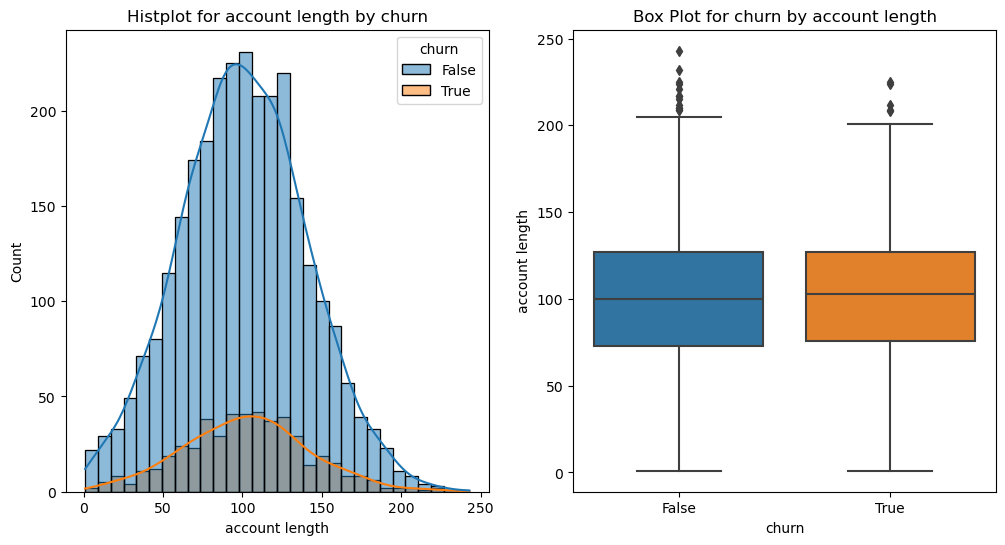

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

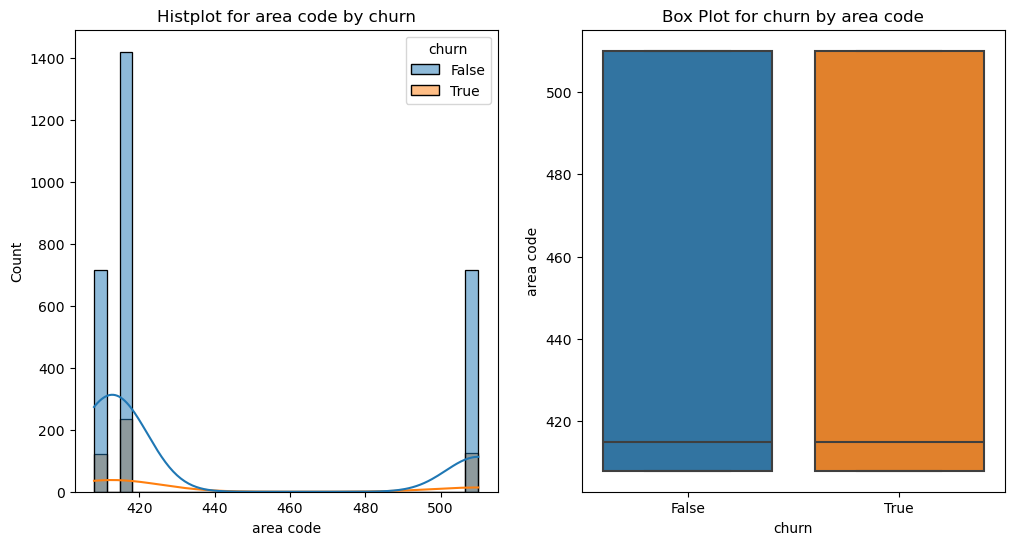

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

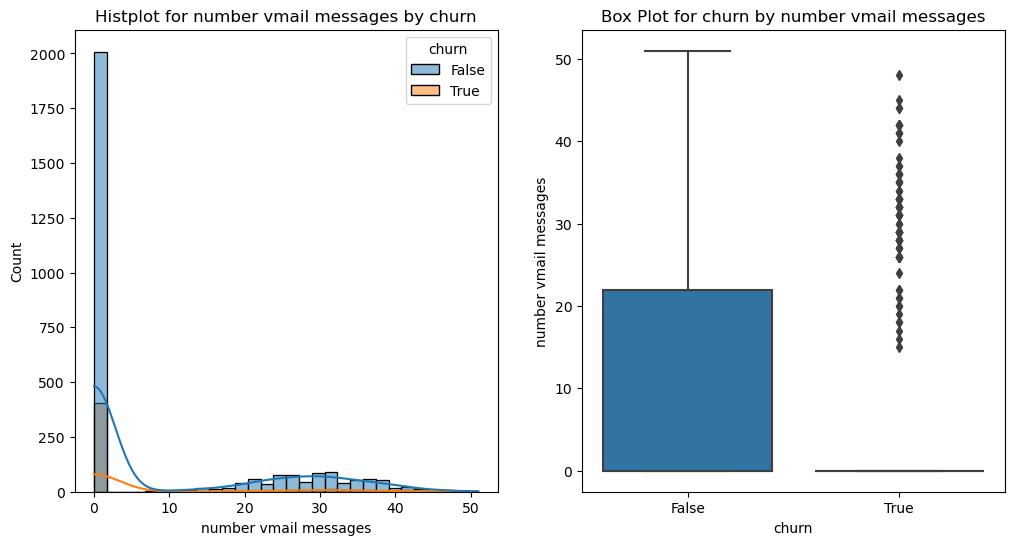

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

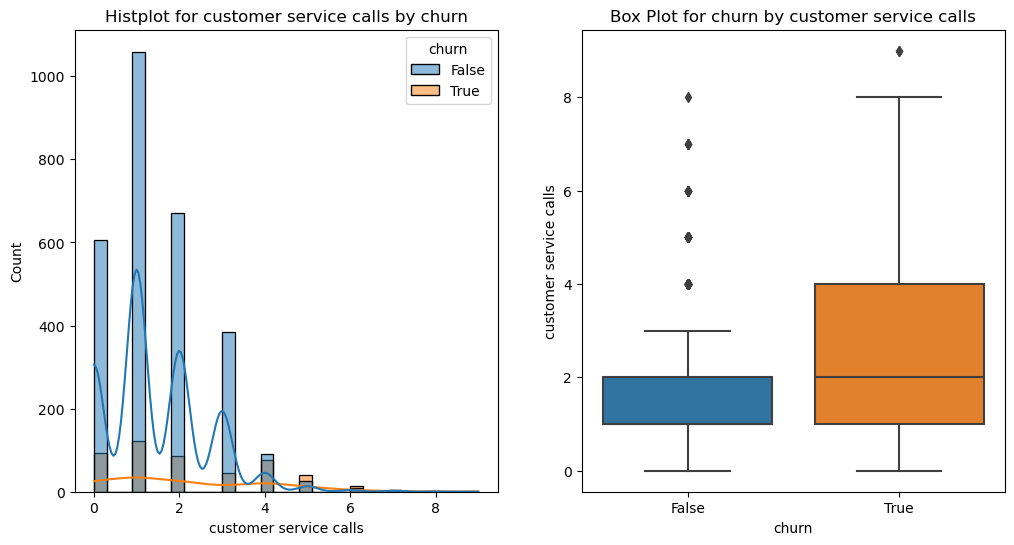

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

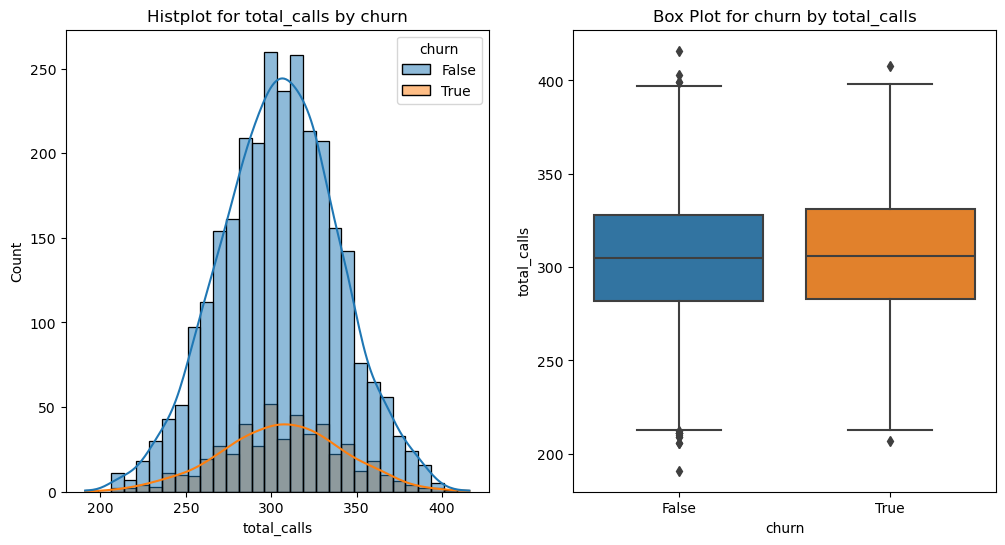

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

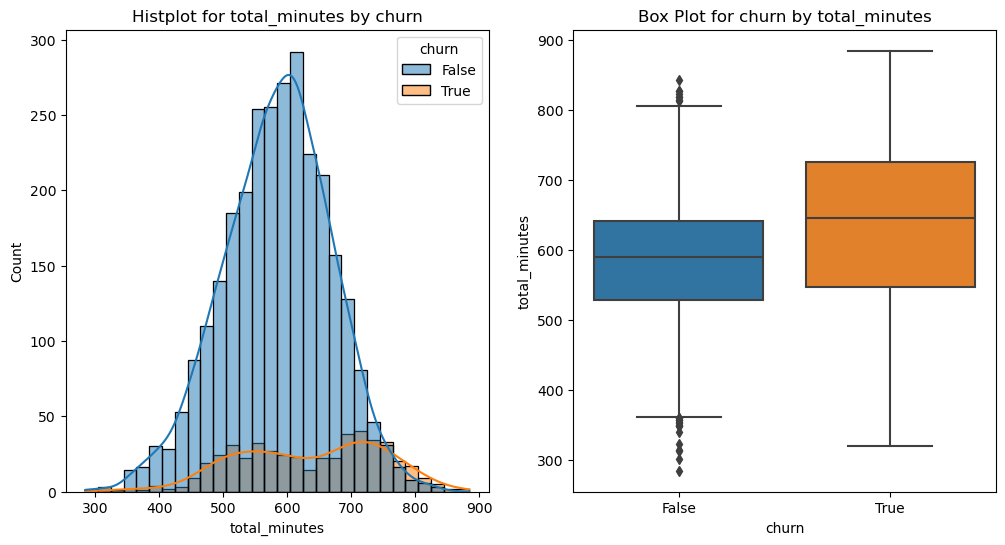

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

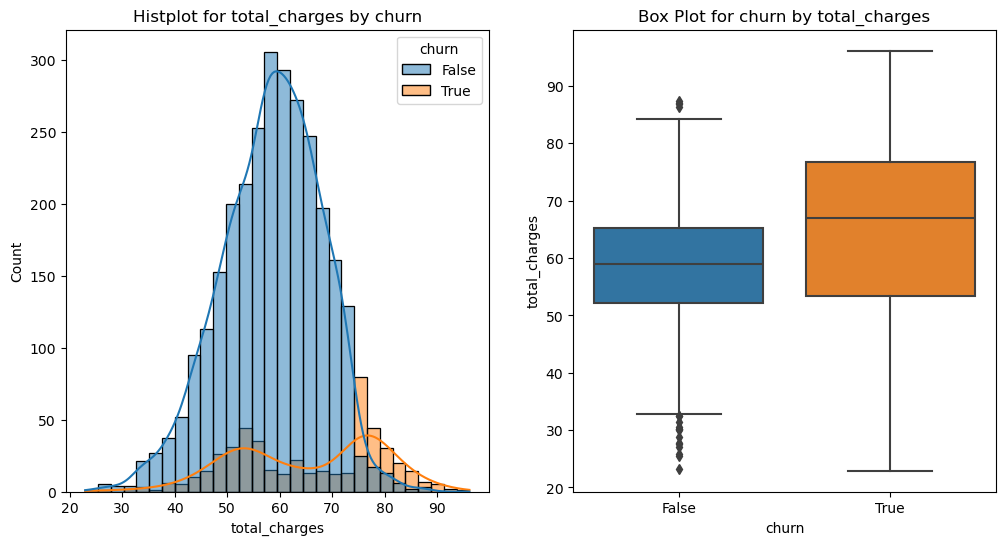

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


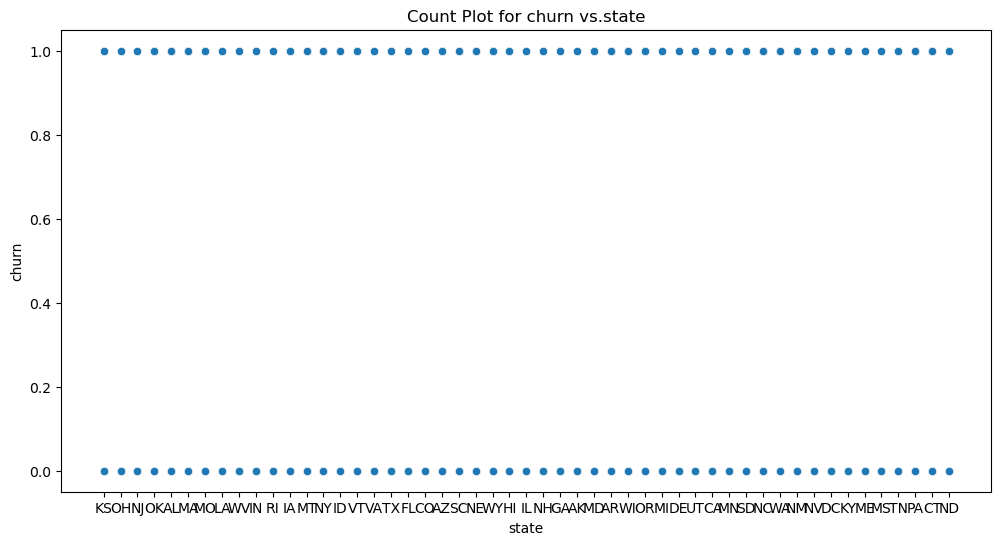

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


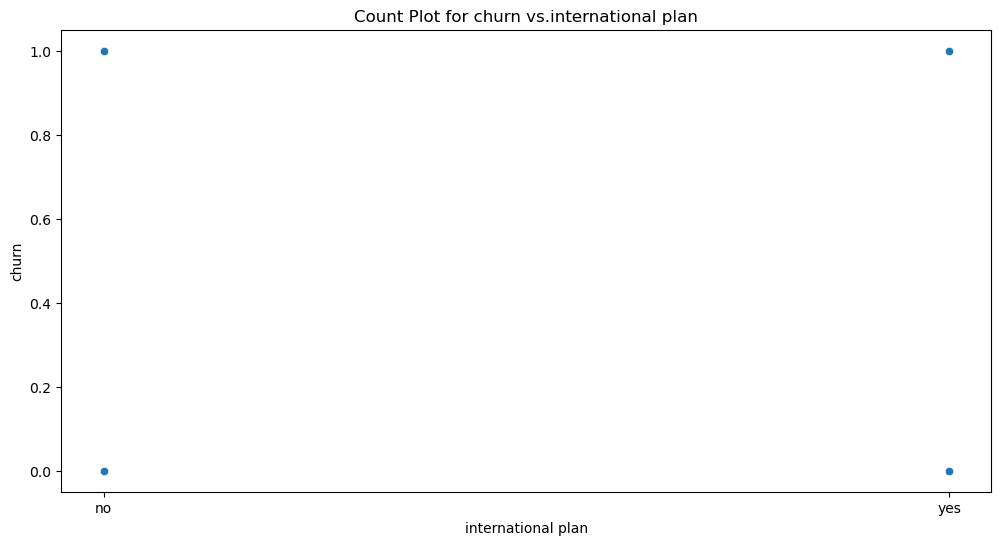

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


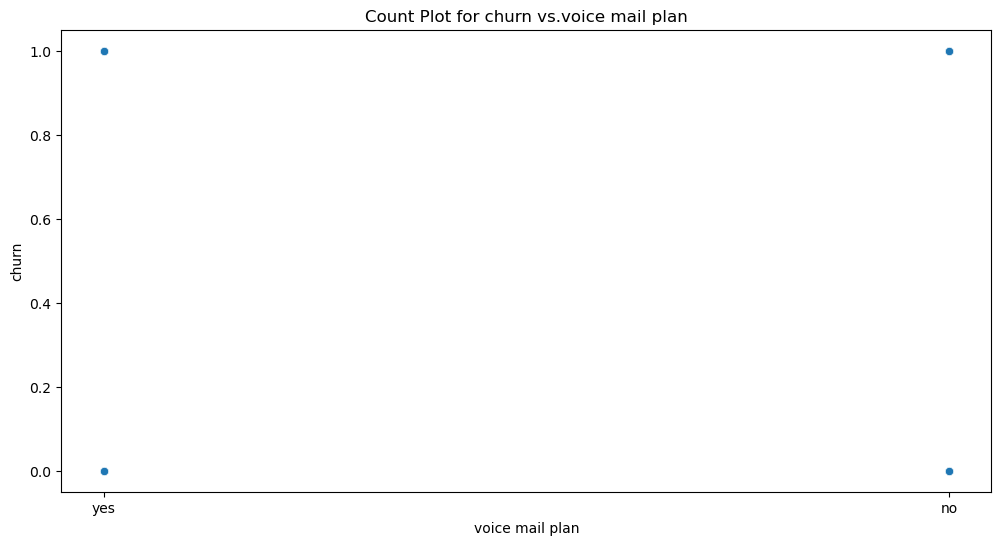

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


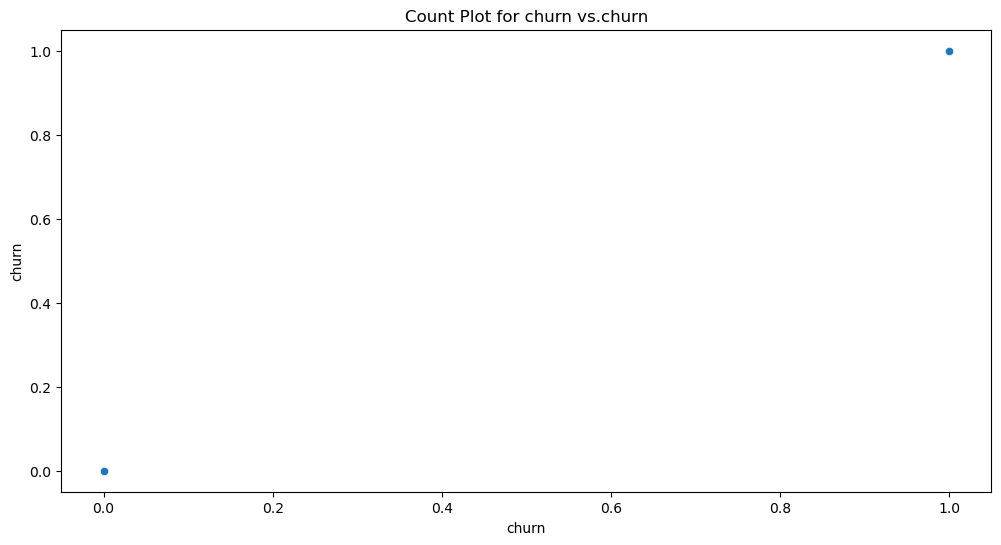

In [44]:
data_analysis.bivariate_analysis(column_of_interest="churn")

## **4. MODELLING**

Now that all the data analysis has been conducted, modelling can now be conducted. 

### 4.1. Model Instantiation
The modelling will begin with the development of a baseline model. However, before that is done, instantiation of a model class needs to be done.

In [45]:
model = Modeling(dataframe=data_analysis.dataframe)

#### 4.2. Data PreProcessing

Further data preprocessing is required, particularly to handle the encoding of categorical variables. For this, we will utilise the `label_encoder` method that will encode the categorical, boolean and discrete data found in the state, international plan, voice mail plan, churn and area code columns

In [46]:
model.label_encoder()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,customer service calls,churn,total_calls,total_minutes,total_charges
0,16,128,1,382-4657,0,1,25,1,0,303,717.2,75.56
1,35,107,1,371-7191,0,1,26,1,0,332,625.2,59.24
2,31,137,1,358-1921,0,0,0,0,0,333,539.4,62.29
3,35,84,0,375-9999,1,0,0,2,0,255,564.8,66.80
4,36,75,1,330-6626,1,0,0,3,0,359,512.0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,192,1,414-4276,0,1,36,2,0,292,660.7,60.10
3329,49,68,1,370-3271,0,0,0,3,0,239,585.4,63.53
3330,39,28,2,328-8230,0,0,0,2,0,264,675.6,67.74
3331,6,184,2,364-6381,1,0,0,2,0,336,517.6,57.53


### 4.3. Train-Test Split

Having carried out our encoding, the data is now divided into a training and test set. The split ratio selected for this was an 80-20 split, with 20% of the data being reserved for testing. This was done by calling the `train_test_split` method. Furthermore, when doing this split, **stratification** was also implemented, thereby ensuring that the proportion of classes is preserved in both training and testing sets.

In [47]:
X_train, X_test, y_train, y_test = model.train_test_split(target_class=("X_train", "y_train"))

#### 4.4. Feature Scaling

Features can be scaled or normalized as desired. Similar-scale characteristics yield superior results for some machine learning methods. This was implemented using the `scale_data` method - which is a `StandardScaler()` under the hood - which was run first prior to any modelling.

#### 4.5. To SMOTE or not to SMOTE?

When to use SMOTE (Synthetic Minority Over-sampling Technique) is determined by the general machine learning approach as well as the unique obstacles given by the dataset. Here are two typical approaches:

##### 4.5.1. Before the Baseline Model:
| Benefits                                                     | Drawbacks                                                                                                                                                                                                 |
| ------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Handling class imbalance issues from the start               | The synthetic samples created by SMOTE may influence the baseline model's performance, and the performance may not correctly represent the model's capacity to generalize to real-world, unbalanced data. |
| Shows how well a classifier works when trained on a dataset. | --                                                                                                                                                                                                        |

If a logistic regression is assumed to be the baseline model, the impact of carrying out a SMOTE before the baseline model would be as follows: 


In [48]:
model_smote_before = Modeling(dataframe=data_analysis.dataframe)

# Carrying out the SMOTE first
model_smote_before.smote(X_train, y_train)

# Generating the baseline model
model_smote_before.logistic(X_train, X_test, y_train, y_test)



              |-----------| Before Oversampling | After Oversampling       |
              | X_train   |   (2666, 10)   |   (4560, 10)   |
              | y_train   |   (2666,)   |   (4560,)   |
              

              <-------- Logistic Regression Results --------->
              Accuracy : 0.8575712143928036
              
              Confusion Matrix : [[554  16]
 [ 79  18]]
              
              Precision Score: 0.5294117647058824
              
              Recall Score: 0.18556701030927836
              
              F1 Score: 0.2748091603053435
              
              Classification Report :
                            precision    recall  f1-score   support

           0       0.88      0.97      0.92       570
           1       0.53      0.19      0.27        97

    accuracy                           0.86       667
   macro avg       0.70      0.58      0.60       667
weighted avg       0.82      0.86      0.83       667

              


(0.8575712143928036,
 array([[554,  16],
        [ 79,  18]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.88      0.97      0.92       570\n           1       0.53      0.19      0.27        97\n\n    accuracy                           0.86       667\n   macro avg       0.70      0.58      0.60       667\nweighted avg       0.82      0.86      0.83       667\n')

##### 4.5.2. After the Baseline Model:
| Benefits                                              | Drawbacks                                                                                                                                                |
| ----------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Clear view of how model performs without oversampling | If the initial class disparity is significant, the baseline model may fail to accurately reflect the minority class, thus leading to biased conclusions. |
| Able to analyse the effect of SMOTE on the model      | --                                                                                                                                                       |

If a logistic regression is assumed to be the baseline model, the impact of carrying out a SMOTE after the baseline model would be as follows: 

In [49]:
model_smote_after = Modeling(dataframe=data_analysis.dataframe)

# Generating a baseline model first
model_smote_after.logistic(X_train, X_test, y_train, y_test)

# Carrying out the SMOTE after the initial model
model_smote_after.smote(X_train, y_train)

# Generating a new logistic model
model_smote_after.logistic(X_train, X_test, y_train, y_test)


              <-------- Logistic Regression Results --------->
              Accuracy : 0.8575712143928036
              
              Confusion Matrix : [[554  16]
 [ 79  18]]
              
              Precision Score: 0.5294117647058824
              
              Recall Score: 0.18556701030927836
              
              F1 Score: 0.2748091603053435
              
              Classification Report :
                            precision    recall  f1-score   support

           0       0.88      0.97      0.92       570
           1       0.53      0.19      0.27        97

    accuracy                           0.86       667
   macro avg       0.70      0.58      0.60       667
weighted avg       0.82      0.86      0.83       667

              

              |-----------| Before Oversampling | After Oversampling       |
              | X_train   |   (2666, 10)   |   (4560, 10)   |
              | y_train   |   (2666,)   |   (4560,)   |
              

              

(0.8575712143928036,
 array([[554,  16],
        [ 79,  18]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.88      0.97      0.92       570\n           1       0.53      0.19      0.27        97\n\n    accuracy                           0.86       667\n   macro avg       0.70      0.58      0.60       667\nweighted avg       0.82      0.86      0.83       667\n')

#### 4.5.3. Which to Choose?

From the investigation done above, it seems like there is no difference in our baseline model if the SMOTE is conducted before or after the creation of the baseline model. For that reason, to eliminate any extra steps as they have been proven redundant, the SMOTE will be conducted **before** the creation of the baseline model. 

If the timing of the SMOTE had any impact in this situation, the score would not be the same in both instances. We will thus call the `smote` method on our original model instance before creating our baseline model.

In [50]:
model.smote(X_train, y_train)


              |-----------| Before Oversampling | After Oversampling       |
              | X_train   |   (2666, 10)   |   (4560, 10)   |
              | y_train   |   (2666,)   |   (4560,)   |
              


#### 4.6. Baseline Model

Having done this, our baseline logistic regression model is now created.

In [51]:
model1 = model.logistic(X_train, X_test, y_train, y_test)


              <-------- Logistic Regression Results --------->
              Accuracy : 0.8575712143928036
              
              Confusion Matrix : [[554  16]
 [ 79  18]]
              
              Precision Score: 0.5294117647058824
              
              Recall Score: 0.18556701030927836
              
              F1 Score: 0.2748091603053435
              
              Classification Report :
                            precision    recall  f1-score   support

           0       0.88      0.97      0.92       570
           1       0.53      0.19      0.27        97

    accuracy                           0.86       667
   macro avg       0.70      0.58      0.60       667
weighted avg       0.82      0.86      0.83       667

              


#### 4.7. 2nd Model

To improve on the baseline model, a **decision tree model** was now developed. All the relevant variables from the baseline model are passed on in a bid to improve the model's accuracy.

In [52]:
model2 = model.decision_tree(X_train, X_test, y_train, y_test)


              <-------- Decision Tree Results --------->
              Accuracy : 0.896551724137931

               Confusion Matrix : [[539  31]
 [ 38  59]]

              Precision Score: 0.6555555555555556

              Recall Score: 0.6082474226804123

              F1 Score: 0.6310160427807486

              Classification Report :
                            precision    recall  f1-score   support

           0       0.93      0.95      0.94       570
           1       0.66      0.61      0.63        97

    accuracy                           0.90       667
   macro avg       0.79      0.78      0.79       667
weighted avg       0.89      0.90      0.89       667

              


#### 4.8. 3rd Model

Seeking a further imporvement in the model, a new model is now developed using the **random forest** model. 

In [53]:
model3=model.random_forest(X_train, X_test, y_train, y_test)


              <-------- Random Forest Results --------->
              Accuracy : 0.9295352323838081%

              Confusion Matrix : [[566   4]
 [ 43  54]]

              Precision Score: 0.9310344827586207

              Recall Score: 0.5567010309278351

              F1 Score: 0.696774193548387

              Classification Report :
                            precision    recall  f1-score   support

           0       0.93      0.99      0.96       570
           1       0.93      0.56      0.70        97

    accuracy                           0.93       667
   macro avg       0.93      0.77      0.83       667
weighted avg       0.93      0.93      0.92       667

              


#### 4.9. 4th Model

To further improve the accuracy, hyperparamter tuning of the random forest model is conducted.

In [54]:
model4=model.hyperparameter_tuning(X_train, X_test, y_train, y_test)


              <-------- Hyperparameter Tuning Results --------->
              Best Model Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
              Accuracy : 0.9400299850074962%

              Confusion Matrix : [[569   1]
 [ 39  58]]
              
              Precision Score: 0.9830508474576272

              Recall Score: 0.5979381443298969

              F1 Score: 0.7435897435897435

              Classification Report :
                            precision    recall  f1-score   support

           0       0.94      1.00      0.97       570
           1       0.98      0.60      0.74        97

    accuracy                           0.94       667
   macro avg       0.96      0.80      0.85       667
weighted avg       0.94      0.94      0.93       667

              


## **4. EVALUATION**


a. Logistic Regression:
Moderate accuracy.
Lower recall for class 1, indicating that it might not perform well in identifying instances of the positive class.

b. Decision Tree:
Good accuracy.
Balanced precision and recall for both classes.
Might be prone to overfitting, as indicated by a high accuracy on the training set.

c. Random Forest:
High accuracy.
High precision for class 1 but lower recall, indicating potential difficulty in identifying all instances of the positive class.

d. Hyperparameter Tuning (Random Forest):
Slight improvement in accuracy.
Better precision, recall, and F1-score for class 1 compared to the untuned random forest.

## **5. RECOMMENDATIONS**

a. Evaluate Imbalanced Classes:
Since the dataset may be imbalanced (especially for class 1), consider using techniques like oversampling, undersampling, or different evaluation metrics tailored for imbalanced datasets.

b. Promote Engagement:
Encourage Value-Added Services, such as Voicemail Plans, to Increase Customer Engagement.

c. Unique and Customisable Mobile Plans:
Match price points to real use to avoid unpleasant surprises and lower the risk of customer attrition.

d. Cross-Validation:
Implement cross-validation to get a more robust estimate of model performance.

e. Ensemble Methods:
Consider using ensemble methods like stacking or boosting to combine the strengths of different models.

f. Domain Knowledge:
If available, incorporate domain knowledge to guide feature engineering or model selection.


Each model has its strengths and weaknesses, and the choice depends on the specific goals and characteristics of the dataset.
Always consider the context and business objectives when interpreting model performance metrics.
Iteratively refine your models based on continuous evaluation and feedback.